In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import itertools

import os
import cv2

2023-05-10 15:53:29.458887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from PIL import Image
import numpy as np

# JPEG 이미지를 2차원 numpy 배열로 변환하는 함수
def jpg_to_2d_np(jpg_path):
    # JPEG 이미지 열기
    img = Image.open(jpg_path)

    # 이미지를 흑백으로 변환
    gray_img = img.convert('L')

    # 이미지를 2차원 numpy 배열로 변환
    np_img = np.array(gray_img)

    return np_img


In [3]:
path = 'dataset' # 데이터셋 경로
image_size = 128 # 이미지 크기
test_size = 0.15 # test set 비율

# 데이터셋 내 폴더들을 리스트로 추출
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

# 각 폴더 내 이미지 파일들을 불러와서 흑백으로 변환하고 라벨링
images = []
labels = []
for i, folder in enumerate(folders):
    image_names = os.listdir(os.path.join(path, folder))
    for image_name in image_names:
        image_path = os.path.join(path, folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image_size, image_size))
        images.append(image)
        labels.append(i)

# 불러온 이미지와 라벨을 numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# train과 test set을 나눔
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

In [4]:
# #load dataset
# data = np.load('230503_data.npz') 

# # load the "Train Images"
# x_train = data['trainX']
# #normalize every image
# x_train = np.array(x_train,dtype='float32')/255

# x_test = data['testX']
# x_test = np.array(x_test,dtype='float32')/255

# # load the Label of Images
# y_train= data['trainY']
# y_test= data['testY']

# show the train and test Data format
print('x_train : {}'.format(X_train.shape))
print('Y-train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(X_test.shape))

x_train : (2465, 128, 128)
Y-train shape: (2465,)
x_test shape: (435, 128, 128)


In [5]:
X_train, X_valid, y_train, y_valid= train_test_split(
    X_train, y_train, test_size=.1766, random_state=1234,)


In [6]:
im_rows=128
im_cols=128
batch_size=128
im_shape=(im_rows, im_cols, 1)
print(im_shape)
#change the size of images
X_train = X_train.reshape(X_train.shape[0], *im_shape)
X_test = X_test.reshape(X_test.shape[0], *im_shape)
X_valid = X_valid.reshape(X_valid.shape[0], *im_shape)

print('x_train shape: {}'.format(X_train.shape))
print('x_test shape: {}'.format(X_valid.shape))

(128, 128, 1)
x_train shape: (2029, 128, 128, 1)
x_test shape: (436, 128, 128, 1)


In [28]:
#filters= the depth of output image or kernels

cnn_model= Sequential([
    Conv2D(filters=72, kernel_size=7, activation='relu', input_shape=im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=72, kernel_size=5, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=72, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(4, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

In [29]:
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 122, 122, 72)      3600      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 61, 61, 72)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 57, 57, 72)        129672    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 28, 28, 72)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 26, 26, 72)        46728     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 13, 13, 72)      

In [30]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history=cnn_model.fit(
    np.array(X_train), np.array(y_train), batch_size=128,
    epochs=250, verbose=2,
    validation_data=(np.array(X_valid),np.array(y_valid)),
    callbacks=[early_stopping]
)

Epoch 1/250
16/16 - 37s - loss: 3.3151 - accuracy: 0.4830 - val_loss: 0.3492 - val_accuracy: 0.9289 - 37s/epoch - 2s/step
Epoch 2/250
16/16 - 37s - loss: 0.5578 - accuracy: 0.7807 - val_loss: 0.1645 - val_accuracy: 0.9541 - 37s/epoch - 2s/step
Epoch 3/250
16/16 - 37s - loss: 0.2130 - accuracy: 0.9315 - val_loss: 0.0672 - val_accuracy: 0.9679 - 37s/epoch - 2s/step
Epoch 4/250
16/16 - 37s - loss: 0.1069 - accuracy: 0.9611 - val_loss: 0.0357 - val_accuracy: 0.9771 - 37s/epoch - 2s/step
Epoch 5/250
16/16 - 37s - loss: 0.0615 - accuracy: 0.9783 - val_loss: 0.0100 - val_accuracy: 0.9977 - 37s/epoch - 2s/step
Epoch 6/250
16/16 - 37s - loss: 0.0449 - accuracy: 0.9842 - val_loss: 0.0067 - val_accuracy: 1.0000 - 37s/epoch - 2s/step
Epoch 7/250
16/16 - 36s - loss: 0.0257 - accuracy: 0.9931 - val_loss: 0.0023 - val_accuracy: 1.0000 - 36s/epoch - 2s/step
Epoch 8/250
16/16 - 38s - loss: 0.0194 - accuracy: 0.9936 - val_loss: 6.6454e-04 - val_accuracy: 1.0000 - 38s/epoch - 2s/step
Epoch 9/250
16/16 - 

KeyboardInterrupt: 

In [14]:
scor = cnn_model.evaluate( np.array(X_test),  np.array(y_test), verbose=0)

print('test los {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

test los 0.0183
test acc 0.9977


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


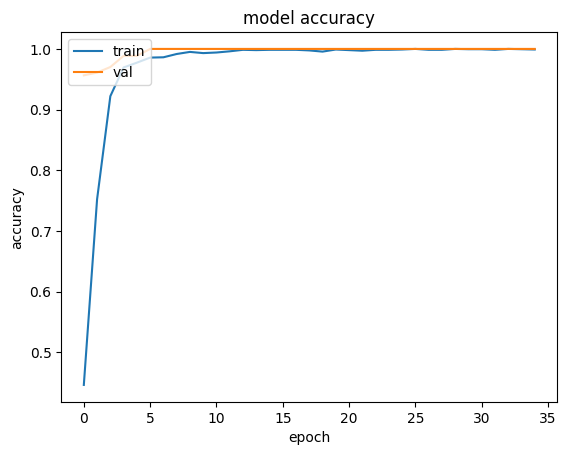

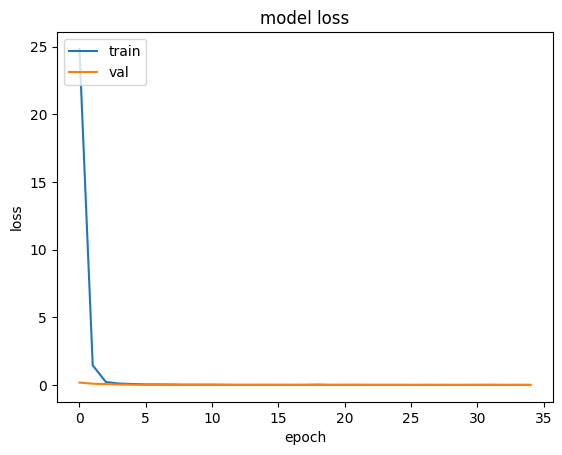

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
predicted = np.array(cnn_model.predict(X_test))
ynew = np.argmax(predicted, axis=1)

print(predicted)
print(y_test)

14/14 [==============================] - 1s 95ms/step
[[9.9999994e-01 3.0113139e-12 7.4006599e-12]
 [5.8473316e-11 9.9999994e-01 1.4973582e-10]
 [9.9999994e-01 2.2453628e-10 5.2665206e-10]
 ...
 [1.0000000e+00 1.8674277e-10 1.8980760e-11]
 [2.8749539e-10 1.0000000e+00 3.5295709e-09]
 [8.5853667e-14 5.9192104e-13 1.0000000e+00]]
[0 1 0 1 2 1 1 2 0 2 1 0 1 0 1 1 0 2 0 2 1 1 1 1 1 2 0 1 2 1 2 1 1 1 1 2 1
 2 2 0 1 1 1 1 2 1 1 1 2 2 1 1 2 0 1 2 1 1 1 1 1 0 0 2 1 1 0 0 2 0 1 0 1 1
 2 1 2 0 1 0 1 2 1 1 1 2 2 1 2 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 2 0 0 0
 0 0 0 0 2 1 2 2 0 2 0 0 0 1 0 1 1 2 1 1 2 2 2 2 2 0 2 2 1 2 2 2 2 1 1 0 1
 2 1 1 2 0 2 2 0 2 1 1 0 1 2 2 0 2 2 2 0 1 2 1 0 1 1 0 1 1 0 1 1 2 1 1 2 0
 2 2 0 2 1 0 0 1 0 0 0 2 1 0 1 0 0 0 2 0 1 1 0 2 0 2 2 0 1 0 1 0 0 1 1 1 2
 1 0 1 2 2 2 1 1 1 2 2 2 1 0 1 0 0 1 2 1 1 1 2 2 1 2 0 1 0 0 2 0 1 0 0 0 1
 0 1 0 0 0 2 1 1 1 2 2 1 0 1 1 0 2 2 1 1 1 2 2 2 0 0 2 0 2 1 0 0 1 0 0 1 1
 0 1 0 2 2 0 2 0 2 2 1 0 2 2 0 0 2 1 0 0 1 0 0 0 1 0 0 0 1 0 1 2 2 0 1

accuracy : 
0.9977011494252873
Confusion matrix, without normalization
[[143   1   0]
 [  0 165   0]
 [  0   0 126]]
Confusion matrix, without normalization


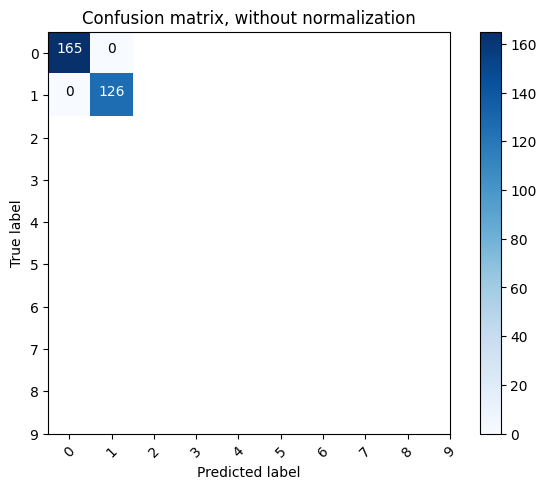

Confusion matrix, without normalization


/tmp/ipykernel_37358/2850457876.py:26: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
/tmp/ipykernel_37358/2850457876.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(cm, interpolation='nearest', cmap=cmap)


ValueError: zero-size array to reduction operation maximum which has no identity

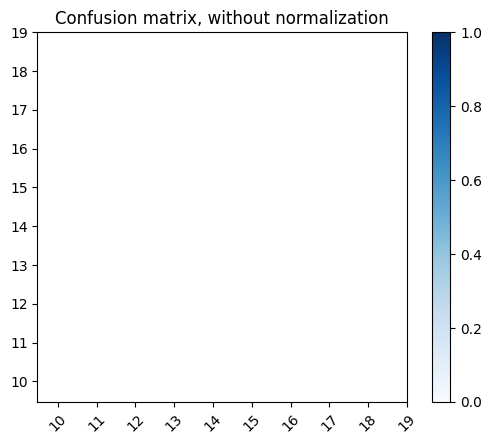

In [18]:
Acc=accuracy_score(y_test, ynew)
print("accuracy : ")
print(Acc)
#/tn, fp, fn, tp = confusion_matrix(np.array(y_test), ynew).ravel()
cnf_matrix=confusion_matrix(np.array(y_test), ynew)

y_test1 = np_utils.to_categorical(y_test, 20)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


print('Confusion matrix, without normalization')
print(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix[1:10,1:10], classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix[11:20,11:20], classes=[10,11,12,13,14,15,16,17,18,19],
                      title='Confusion matrix, without normalization')

print("Confusion matrix:\n%s" % confusion_matrix(np.array(y_test), ynew))
print(classification_report(np.array(y_test), ynew))


In [19]:
from keras.models import load_model

# 모델을 저장할 경로와 파일 이름을 지정
model_path = 'my_model.h5'

# 모델 저장
cnn_model.save(model_path)

## batch = 256

In [ ]:
#load dataset
data = np.load('230503_data.npz') 

# load the "Train Images"
x_train = data['trainX']
#normalize every image
x_train = np.array(x_train,dtype='float32')/255

x_test = data['testX']
x_test = np.array(x_test,dtype='float32')/255

# load the Label of Images
y_train= data['trainY']
y_test= data['testY']

# show the train and test Data format
print('x_train : {}'.format(x_train[:]))
print('Y-train shape: {}'.format(y_train))
print('x_test shape: {}'.format(x_test.shape))

In [ ]:
for key, value in data.items():
    print(key, value)

In [ ]:
x_train, x_valid, y_train, y_valid= train_test_split(
    x_train, y_train, test_size=.05, random_state=1234,)


In [ ]:
im_rows=256
im_cols=256
batch_size=256
im_shape=(im_rows, im_cols, 1)

#change the size of images
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

print('x_train shape: {}'.format(y_train.shape[0]))
print('x_test shape: {}'.format(y_test.shape))

In [ ]:
#filters= the depth of output image or kernels

cnn_model= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(20, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

cnn_model.summary()

In [ ]:
history=cnn_model.fit(
    np.array(x_train), np.array(y_train), batch_size=256,
    epochs=250, verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid)),
)

In [ ]:
scor = cnn_model.evaluate( np.array(x_test),  np.array(y_test), verbose=0)

print('test los {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predicted = np.array(cnn_model.predict(x_test))
ynew = np.argmax(predicted, axis=1)

print(predicted)
print(y_test)

In [ ]:
Acc=accuracy_score(y_test, ynew)
print("accuracy : ")
print(Acc)
#/tn, fp, fn, tp = confusion_matrix(np.array(y_test), ynew).ravel()
cnf_matrix=confusion_matrix(np.array(y_test), ynew)

y_test1 = np_utils.to_categorical(y_test, 20)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


print('Confusion matrix, without normalization')
print(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix[1:10,1:10], classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix[11:20,11:20], classes=[10,11,12,13,14,15,16,17,18,19],
                      title='Confusion matrix, without normalization')

print("Confusion matrix:\n%s" % confusion_matrix(np.array(y_test), ynew))
print(classification_report(np.array(y_test), ynew))

## batch = 512

In [ ]:
#load dataset
data = np.load('230503_data.npz') 

# load the "Train Images"
x_train = data['trainX']
#normalize every image
x_train = np.array(x_train,dtype='float32')/255

x_test = data['testX']
x_test = np.array(x_test,dtype='float32')/255

# load the Label of Images
y_train= data['trainY']
y_test= data['testY']

# show the train and test Data format
print('x_train : {}'.format(x_train[:]))
print('Y-train shape: {}'.format(y_train))
print('x_test shape: {}'.format(x_test.shape))

In [ ]:
for key, value in data.items():
    print(key, value)

In [ ]:
x_train, x_valid, y_train, y_valid= train_test_split(
    x_train, y_train, test_size=.05, random_state=1234,)


In [ ]:
im_rows=256
im_cols=256
batch_size=512
im_shape=(im_rows, im_cols, 1)

#change the size of images
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

print('x_train shape: {}'.format(y_train.shape[0]))
print('x_test shape: {}'.format(y_test.shape))

In [ ]:
#filters= the depth of output image or kernels

cnn_model= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(20, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

cnn_model.summary()

In [ ]:
history=cnn_model.fit(
    np.array(x_train), np.array(y_train), batch_size=512,
    epochs=250, verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid)),
)

In [ ]:
scor = cnn_model.evaluate( np.array(x_test),  np.array(y_test), verbose=0)

print('test los {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predicted = np.array(cnn_model.predict(x_test))
ynew = np.argmax(predicted, axis=1)

print(predicted)
print(y_test)

In [ ]:
Acc=accuracy_score(y_test, ynew)
print("accuracy : ")
print(Acc)
#/tn, fp, fn, tp = confusion_matrix(np.array(y_test), ynew).ravel()
cnf_matrix=confusion_matrix(np.array(y_test), ynew)

y_test1 = np_utils.to_categorical(y_test, 20)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


print('Confusion matrix, without normalization')
print(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix[1:10,1:10], classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix[11:20,11:20], classes=[10,11,12,13,14,15,16,17,18,19],
                      title='Confusion matrix, without normalization')

print("Confusion matrix:\n%s" % confusion_matrix(np.array(y_test), ynew))
print(classification_report(np.array(y_test), ynew))